# Run hacked AlphaFold2 on the designed paired state X's

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_shifties
running on node: dig61


### Set working directory to the root of the crispy_shifty repo
Note: We want to use perlmutter

In [ ]:
os.chdir("/global/cfs/cdirs/m3962/projects/crispy_shifty")

### Fix the paths
Necessary because we are on perlmutter

In [ ]:
# from crispy_shifty.utils.io import fix_path_prefixes

# folded = os.path.join(
#     os.getcwd(),
#     "projects/crispy_shifties/07_fold_paired_states_Y/folded_paired_states.pair",
# )
# new_folded = fix_path_prefixes(
#     find="/mnt/home/pleung",
#     replace="/global/cfs/cdirs/m3962",
#     file=folded,
#     overwrite=True,
# )

### Run AF2 on the designed paired state X's

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "08_fold_paired_states_X"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/07_fold_paired_states_Y/folded_paired_states.pair",
)
output_path = os.path.join(f"/pscratch/sd/p/pleung/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {"models": "3"}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_paired_state_X",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="28:00",  # TODO
)

### Set working directory to the root of the crispy_shifty repo
Note: We rsync the perlmutter results, now back on the digs

In [2]:
os.chdir("/projects/crispy_shifty")

### Collect scorefiles of the folded paired state Xs and concatenate

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "08_fold_paired_states_X"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile
TODO might have to switch to a dask accelerated approach for production

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/13725 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [6]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [7]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [8]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

### Remove score terms we don't care about

In [9]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

1080
['bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'interface', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_msd_design_area', 'mpnn_msd_temperature', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'recycles', 'rmsd_to_input', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type', 'score', 

In [10]:
from crispy_shifty.plotting.utils import histplot_df, pairplot_df

to_plot = [
    "best_average_plddts",
    "best_model",
    "best_ptm",
    "best_rmsd_to_input",
    "cms_AcB",
    "cms_AnAc",
    "cms_AnAcB",
    "cms_AnB",
    "designed_by",
    "interface",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_interaction_AB",
    "mean_pae_interaction_BA",
    "mean_pae_intra_chain",
    "mean_pae_intra_chain_A",
    "mean_pae_intra_chain_B",
    "mean_plddt",
    "mismatch_probability_parent",
    "pTMscore",
    "packstat_parent",
    "pdb",
    "recycles",
    "rmsd_to_reference",
    "sap_parent",
    "sc_AcB",
    "sc_AnAc",
    "sc_AnAcB",
    "sc_AnB",
    "sc_all_parent",
    "score_per_res",
    "score_per_res_parent",
    "ss_sc",
    "state",
    "topo",
]
print(to_plot)

['best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'interface', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'pTMscore', 'packstat_parent', 'pdb', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'score_per_res', 'score_per_res_parent', 'ss_sc', 'state', 'topo']


### Plot before and after multistate design AF2 metrics

6it [00:00, 18.96it/s]


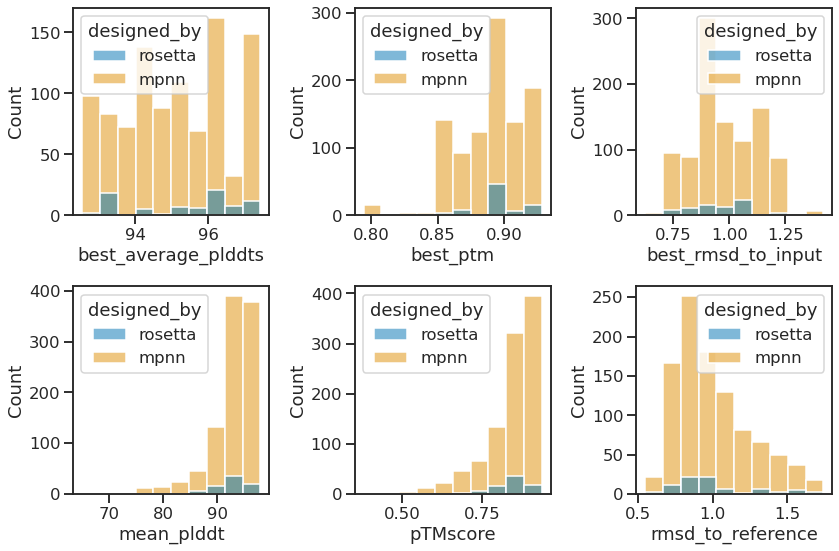

In [11]:
cols = [
    "best_average_plddts",
    "best_ptm",
    "best_rmsd_to_input",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

<Figure size 1728x1728 with 0 Axes>

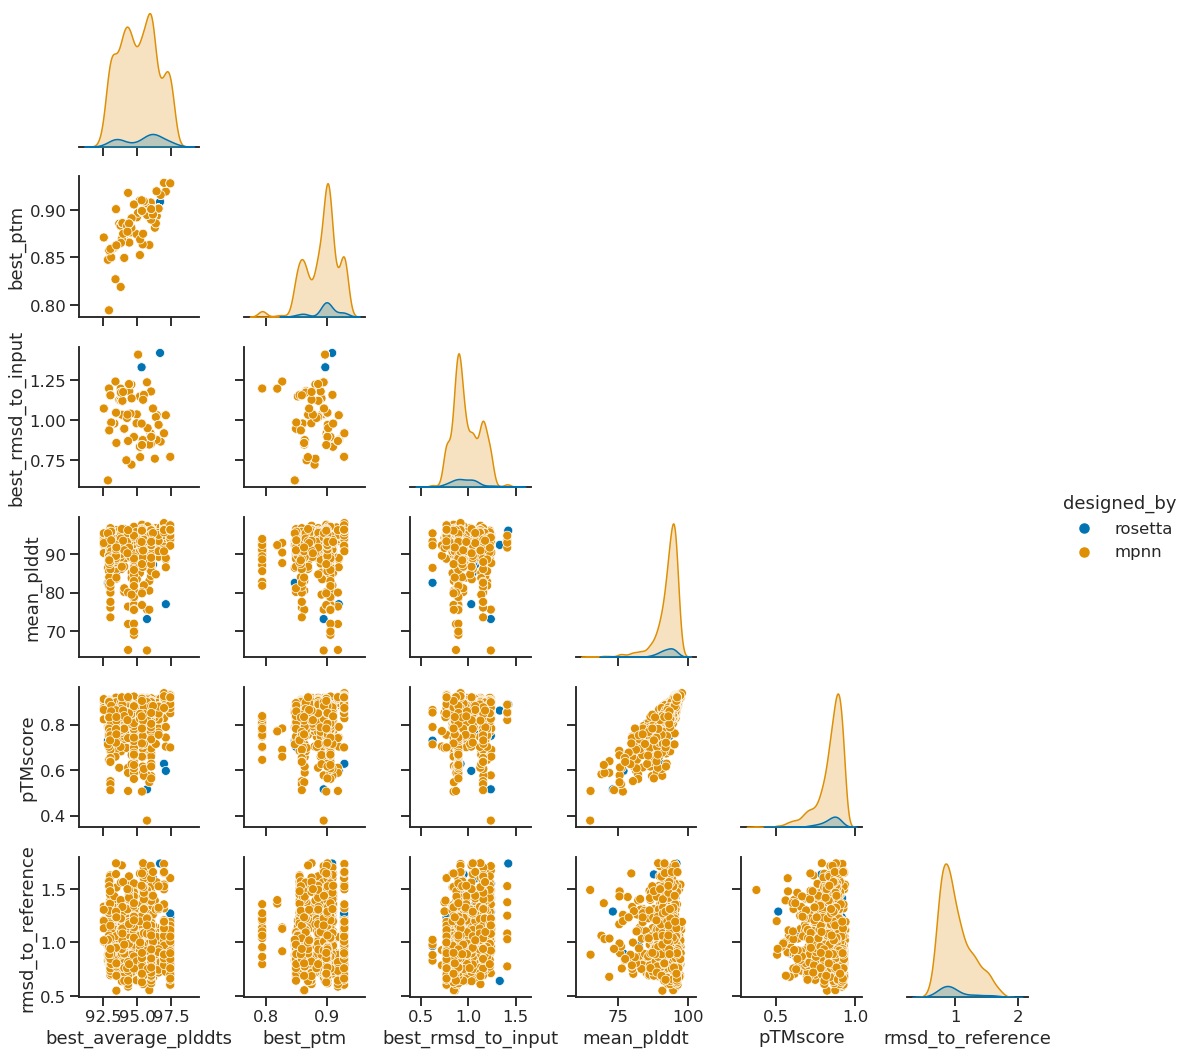

In [12]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_paired.png"))

In [13]:
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="interface",
# )

In [14]:
# the_fig = pairplot_df(
#     df=sample_df,
#     cols=cols,
#     hue="interface",
# )

### Plot effects of MPNN temperature and selector areas on AF2 metrics

In [15]:
# mpnn["mpnn_temperature"] = mpnn["mpnn_temperature"].astype(str)

# cols = [
#     "best_average_plddts",
#     "best_ptm",
#     "best_rmsd_to_input",
#     "mean_plddt",
#     "pTMscore",
#     "rmsd_to_reference",
# ]
# the_fig = histplot_df(
#     df=mpnn,
#     cols=cols,
#     bins=10,
#     hue="mpnn_temperature",
# )

In [16]:
# the_fig = pairplot_df(
#     df=mpnn,
#     cols=cols,
#     hue="mpnn_temperature",
# )

6it [00:00, 14.88it/s]


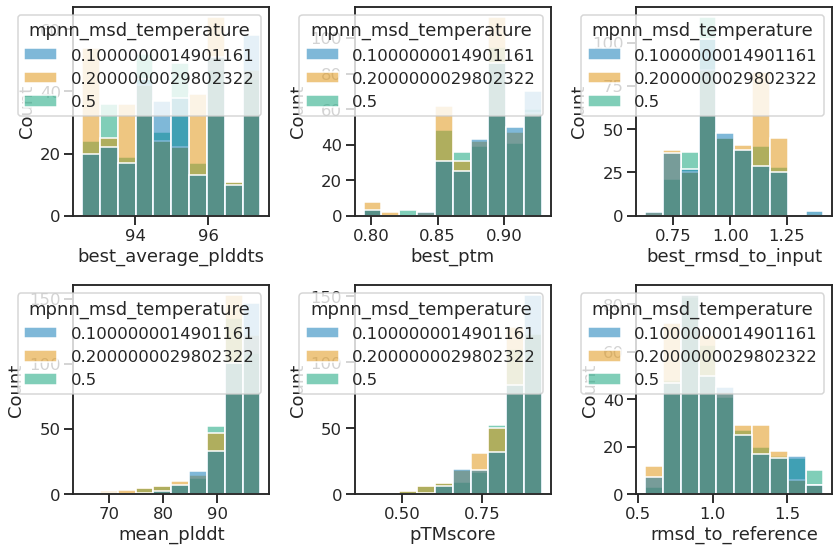

In [17]:
mpnn["mpnn_msd_temperature"] = mpnn["mpnn_msd_temperature"].astype(str)

cols = [
    "best_average_plddts",
    "best_ptm",
    "best_rmsd_to_input",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_temperature",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_temp.png"))

<Figure size 1728x1728 with 0 Axes>

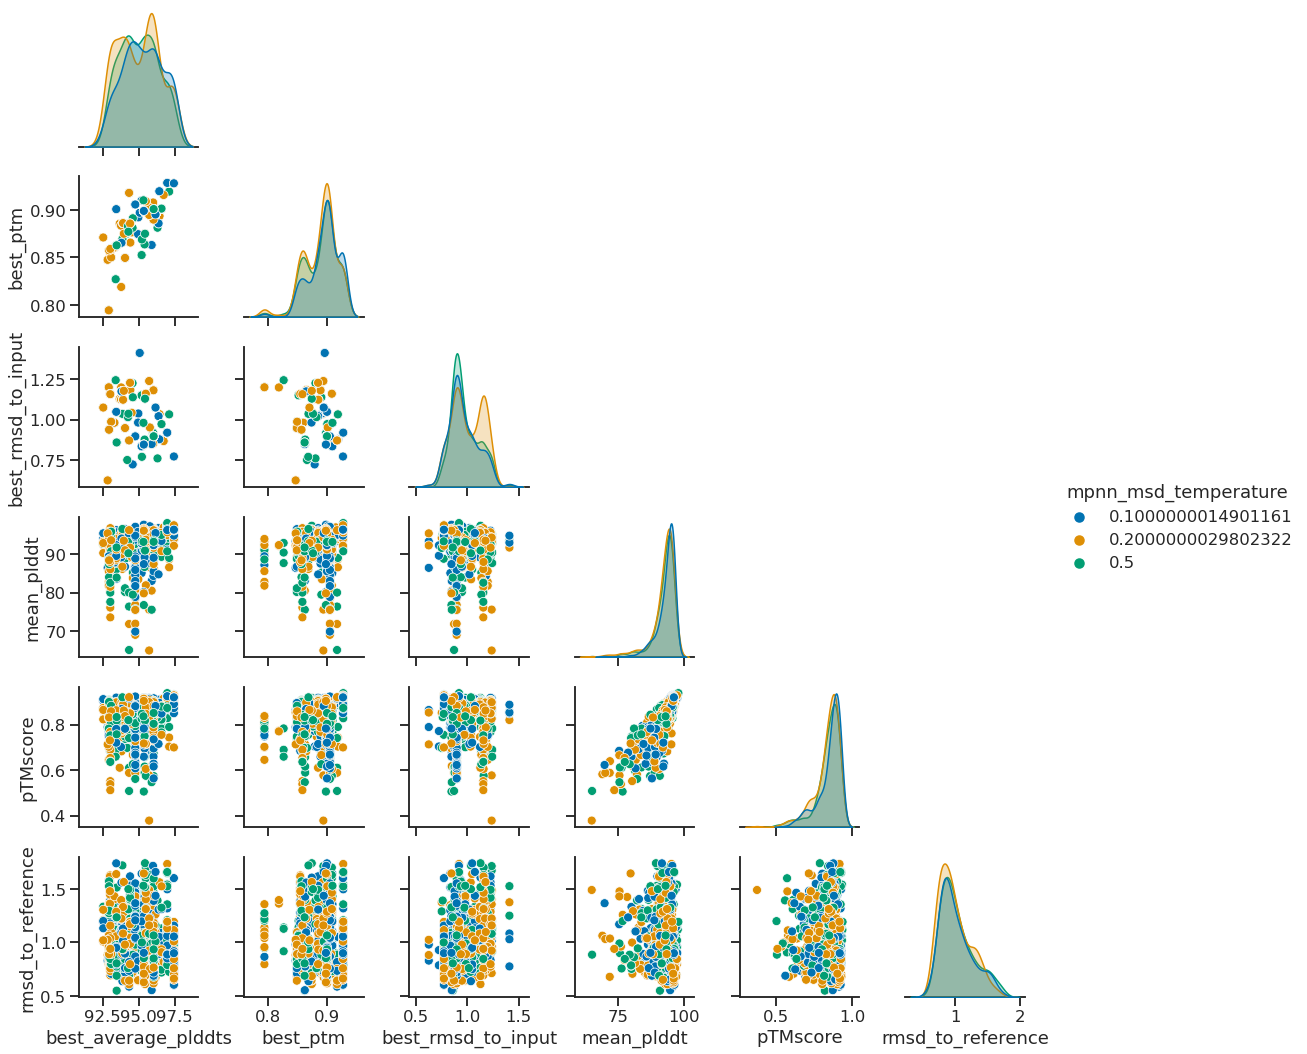

In [18]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_temperature",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_temp_paired.png"))

6it [00:00, 15.77it/s]


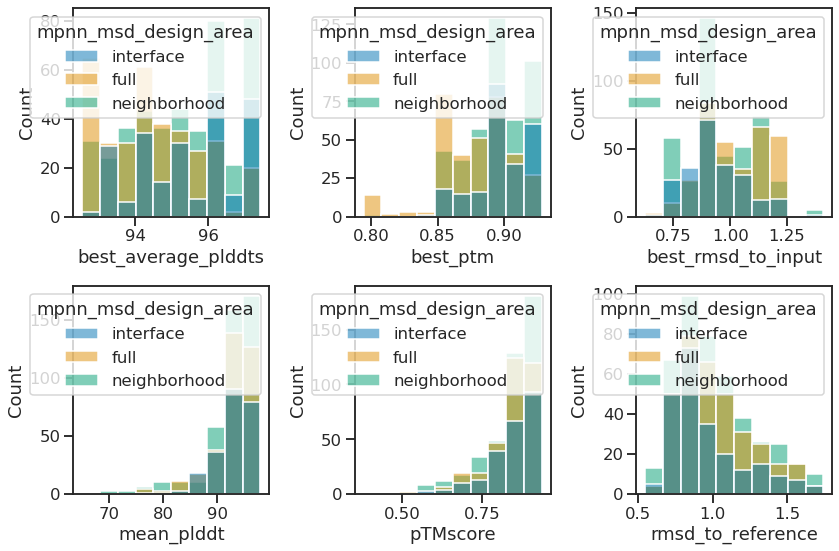

In [19]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area.png"))

<Figure size 1728x1728 with 0 Axes>

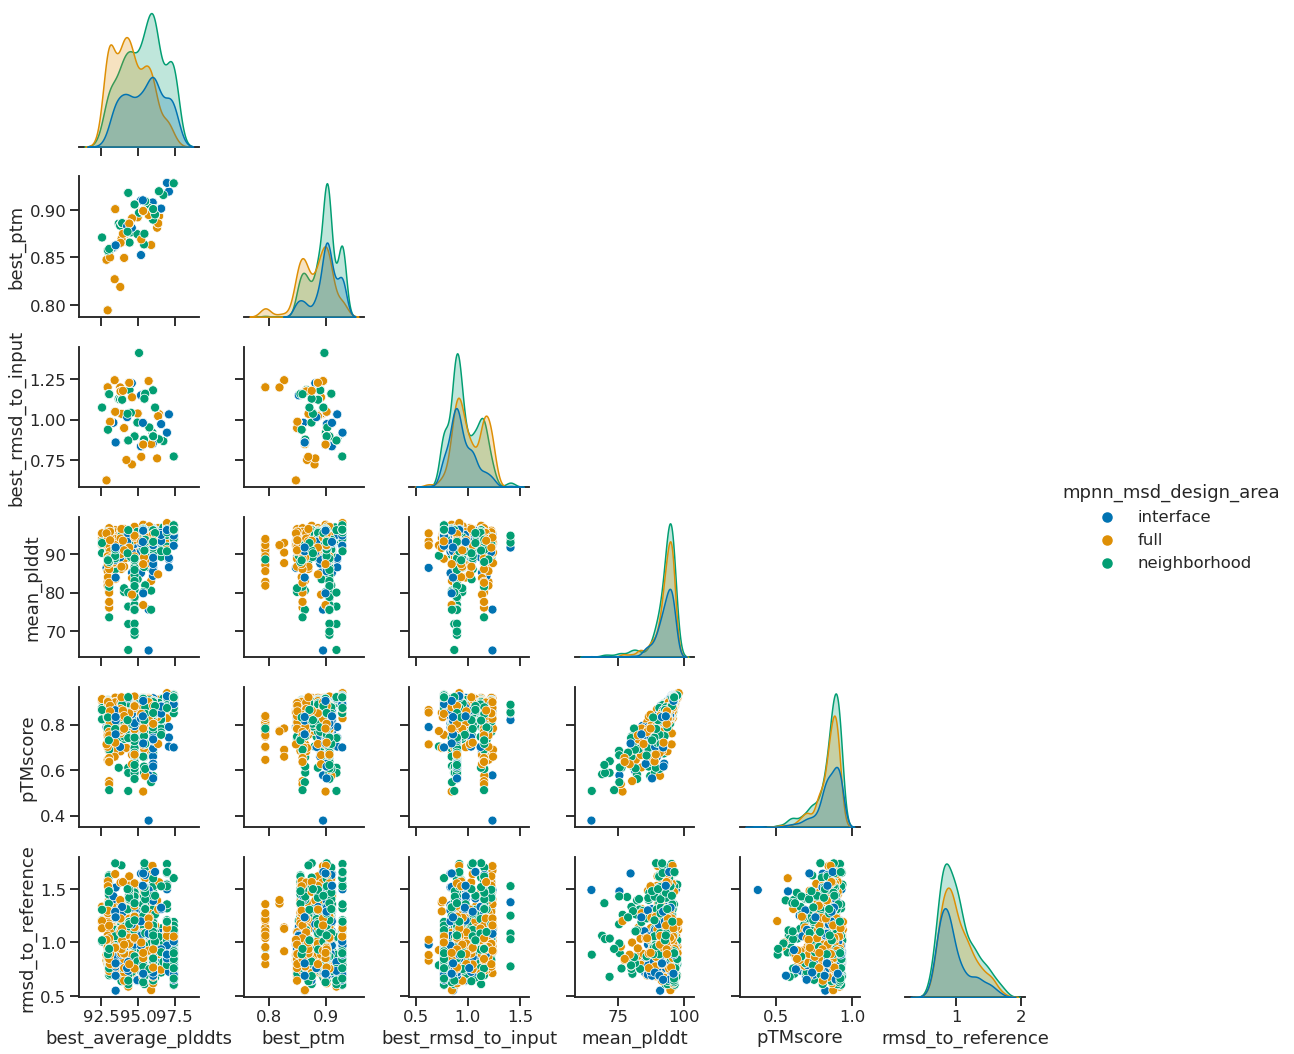

In [20]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

In [21]:
# sample_df["best_model"] = sample_df["best_model"].astype(str)
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="best_model",
# )

In [22]:
# sample_df["best_model"] = sample_df["best_model"].astype(str)
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="topo",
# )

### Plot effects of MPNN temperature and selector areas on interface metrics

2it [00:00, 11.50it/s]


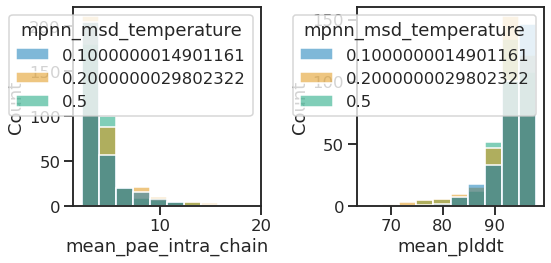

In [23]:
cols = [
    "mean_pae_intra_chain",
    "mean_plddt",
]
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_temperature",
)
# plt.savefig(os.path.join(output_path, "interface_scores_temp.png"))

<Figure size 576x576 with 0 Axes>

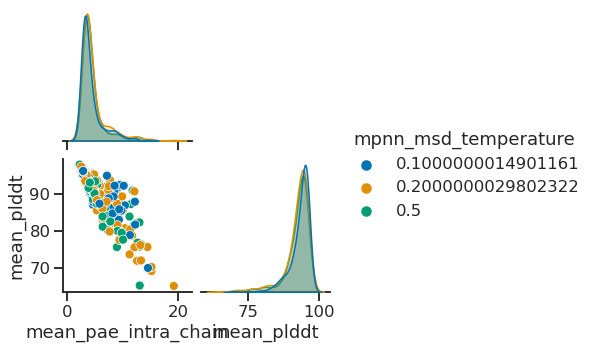

In [24]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_temperature",
)
# plt.savefig(os.path.join(output_path, "interface_scores_paired.png"))

2it [00:00, 13.30it/s]


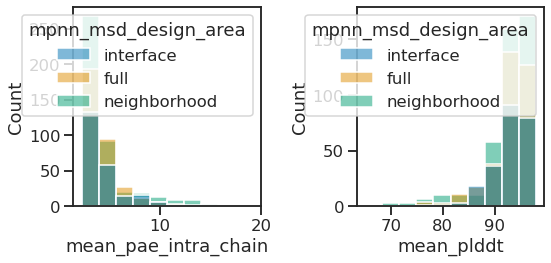

In [25]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_design_area",
)
# plt.savefig(os.path.join(output_path, "interface_scores_area.png"))

<Figure size 576x576 with 0 Axes>

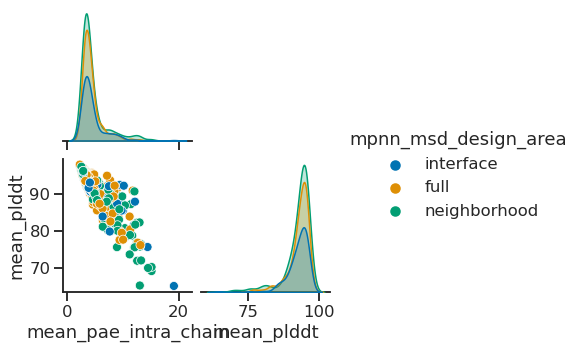

In [26]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_design_area",
)
# plt.savefig(os.path.join(output_path, "interface_scores_area_paired.png"))

### Filter the whole df

In [29]:
query = "mean_plddt > 92 and rmsd_to_reference < 1.5"

filtered = scores_df.query(query)
len(filtered)

9351

In [34]:
print(list(sorted(set([v for v in filtered.parent.values if len(v) == 5]))))

['DHR20', 'DHR21', 'DHR26', 'DHR27', 'DHR49', 'DHR52', 'DHR54', 'DHR59', 'DHR70', 'DHR80', 'DHR81', 'DHR82']


### Plot topo and scaffold_type fraction before and after

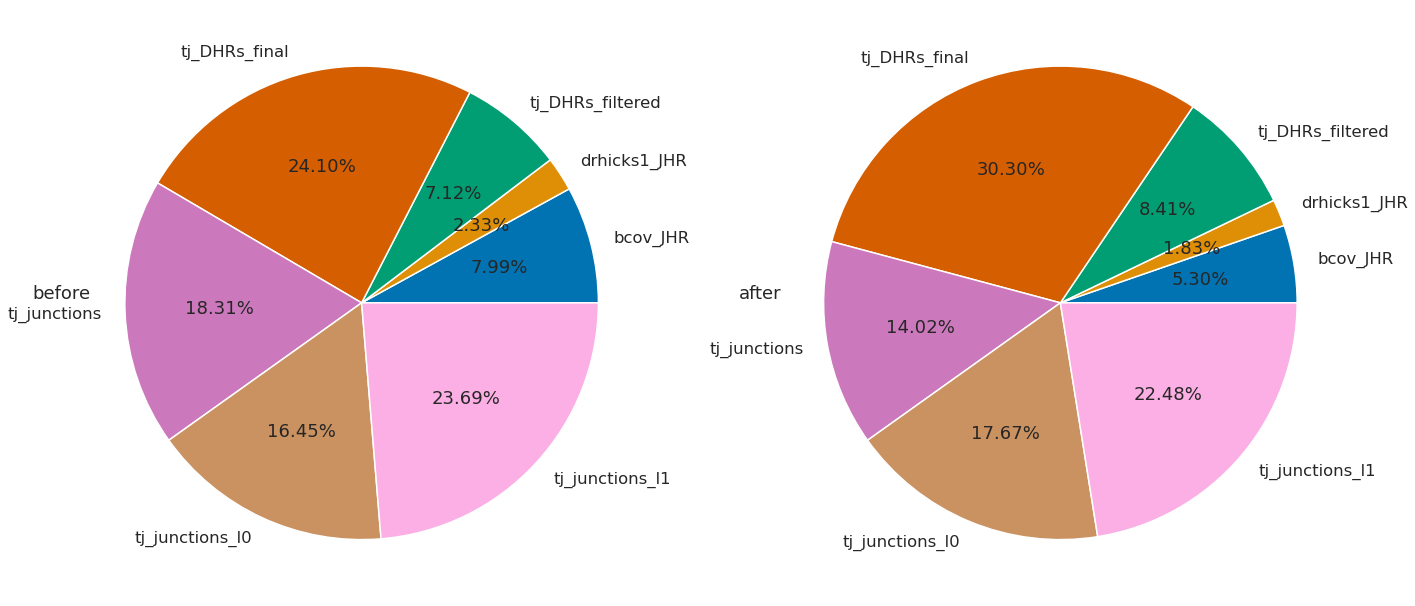

In [35]:
(
    fig,
    (ax1, ax2),
) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("scaffold_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
ax1.set_ylabel("before", rotation=0)
filtered.groupby("scaffold_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
ax2.set_ylabel("after", rotation=0)

plt.savefig(os.path.join(output_path, "filtering_effect_scaffold_type.png"))

### Save a list of outputs

In [36]:
simulation_name = "08_fold_paired_states_X"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "folded_paired_states.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/9351 [00:00<?, ?it/s]

### Prototyping blocks

test `fold_paired_state_X`

In [ ]:
%%time 
from operator import gt, lt
import pyrosetta

# filter_dict = {
#     "mean_plddt": (gt, 85.0),
#     "rmsd_to_reference": (lt, 2.2),
#     "mean_pae_interaction": (lt, 10.0),
# }

pyrosetta.init()


sys.path.insert(0, "~/projects/crispy_shifty/") # TODO projects
from crispy_shifty.protocols.folding import fold_paired_state_X

t = fold_paired_state_Y(
        None,
        **{
            "filter_dict": {},
            "models": [3], # TODO
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_760c687ae53646b59bd36bbe91998593.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_2118b14f45e849ac99034c2e36a8230f.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_806db75a0f8949119a54d50ee8c28576.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_bf4fc1710acb4037917254ce283a7223.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1984895bd0d744e7b7c82446e07b8189.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_ff38fa4457a84da1b0d95850f99b6f10.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c712e867dda84adab431812f7d1ed004.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5b83ffb2312944f084a5557ed82ed5d9.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_b319b9e9da43467596e807f54262cde2.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_fecc3fb836b24903af7b13df546ea87c.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1d931fe681f0482098275e4fd0749d3e.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_e942561def5b4e4491b3c9d9b2d15f76.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_b4791741764a4a1eb28a624286d32a12.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_261a0384260a4d169bab95c703574b15.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5ff0e503a5704aa39ed3b721793432e5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_ea30c907f4d54a0a807e2b3475004032.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a62763836a9a4543858b45840ede8c70.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d2efc01301a74800b6f5669dba46434b.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_b60157d157614d5eb8d540ec1cad6cbd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d66fa964e5d545feaa20bd131bb372d5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c3e8d46a19c3441fb1c02e6ab8cc0f1e.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f763ddc8862f4716ab73613645b818b5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_b5c33cfd51c74dfa8259136db8fc02e9.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_00e8a2bb6e3241a78f3688a5727f53ca.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1e151d604abe47aca2d3b0d2ca8449bd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_dda3a86db52549d5881ea816b39fe2fa.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_497eff9bccbc466999ac1445d8c72307.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_35a59b20c8a342dab46b094dc085fbbe.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_9e1e91449de0489a95ecd922947c130c.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_45c296059f6a45879dd55ddb1909bdfd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_9a8528df5cdd405d81a1d825e281a7d8.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_23965c49bce44dc88f1d373832948c11.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_45dce59a18a742b28c5ade3172290005.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c6f1549c40824fe4a7b71e548ae44237.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_96b04c0f1f834a07a0de2240712e91dd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_2e6f7255b1344097b82f1ce9d29b9117.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_0c915ad2756c4728ae0e5292ae9aa73e.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_018f599f71d649bda48372a0f63a6337.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_892f31cdce9e4265b491359fc274d050.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_ab90cfa6b99f4df792b36c5afc737631.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_e8d8ae2c9c684a1c927ca22d0cfee18f.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a2998e9517124945844771da288f5ad0.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_335f541ac8084aaa99ecae31bada0095.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_bd0143a910f14248a19c9c8b4d05a551.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_9bd90f2f947642ec8e45dc9aa29cd095.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_bd53adc3fba34f378958fb65820ff1c5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_7dfa893d4bee4a4a961c70f127e33c13.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d44931e5caf743bab11932b80e2659ff.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_63921631bf6e44d19d5c978877f830f7.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_25f37915e4d74cef85291bc417db4118.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_12f06b9607dc4f19b6bd12e99f4514ec.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_28182b7490bb430eae7ccde30a0d2754.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d9c4a62d284c44258cfa185e6cffddcb.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5b58abbc36184d88b4039d156541ad04.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_90772bccd98e42bc821ffc28da0aa225.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f4a09a7f494f49fea4c1535328dc615d.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c8a9c5ba7e9b490ca72b98e86182cc22.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a06efe01bba64d39992b001faf05be0c.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d313e754e58a4005a3a1ab885ac2efbb.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_6061f155ab794b0b83f6f2e19db15473.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_3f2369ac5c0c471b9e686b782f761244.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_410e3919547f4adcaedcf972769a6950.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_56f46e89edfb4d83a2102e142f7c1f56.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_9f89cb16e6bf4b26b7f55722659e0596.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_26c2d2d3350d47e28ea86a272299987a.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_507d748832f242d79d589557ff8f8c3a.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5ea6d6ffdf7b4d66b4a1d1fd5de60175.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_986cd31fdbfa47e4af3111b964db5e11.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f78e47f8d1ea4bf59b53425b29726f96.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5c820da32f73451d847e5e6a3abad86d.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_676b0769624245b9a34e6dfa1dee3ef5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c97be179d46f4ec08a34153b42b68b0c.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_981e6b2cb50f41f8aee5bda9c8a50c71.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_08c4e9c1de034b09a59add4f767fe65a.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_e1815ba370b64285ae5000b3d4b16292.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_70cf0471881146ac93054f9082a17639.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5d84254a968e481dba4592d3e2b63dc6.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1b757e1311cc4456a7c510042261493d.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_26f9b1b83be1413c87f681543221cac9.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f76a614bd449489182e987ecb13a9ce0.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_7f3c8d9f96ba4ec68596a11422725cdd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a6429f90372e4cc8a85b415188914a55.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_403c1f10d975414e890a0b9b280eaf0a.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a582f049287b4b598403c0fd82d217b2.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1d427ef8b2cf43959c61847fef0c9e89.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_10a2d6c9762f4a54ba7c21aecae4b270.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_586163d0e4134e5dbe52efab1a0d67c3.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_4a79bf27aad4406a87f99b23dcbddce7.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_3861ea9bae014dc88c63763f909f0a54.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_8272675c92b84570a0386ad84498991b.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_68c8c93fc0444e4ca2e1fbf1151d944b.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_646b1f3e41244da5ae625cc8c7668de4.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d086fd3d9e2c490faf45e8c60ff3fb93.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_e7f52917fe494a20a32d89860fd906b6.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f9fd36225b9441fa92107490d388efb5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1da1cf24ec7a4e6ca139ab3dba7752c5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d34ed61477704b7eb443640b82c1cc3c.pdb.bz2',
        }
)
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
tppose.pose.scores